In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import time

In [3]:
## DEFAULTS

# All times are in ms.

# Conductance of soma
g_l = 0.1
g_d = 2

# Dendritic learning
eta = 0.07
tau_delta = 100

# Synaptic weights
mu = 0.2
w_mean = mu
w_std = 2*mu

# Sigmoidal fxn 
psi_max = 0.15
k = 0.5
beta = 5
vc = 1
sigmoidal = lambda x : psi_max / (1 + k * tf.exp(beta * (vc - x)))
grad_log_sigmoidal = lambda x : beta / (1 + 1/k * tf.exp(beta * (x - vc)))

# Noise fxn
noise_std = 0.0

# Define somatic current input
E_e = 4.667
E_i = -1/3
g_e_ref = 1.0
g_i_ref = 2.0

In [4]:
class neuron_layer():
    
    def __init__(self,layer_size,layer_dendritic_input=None,name = None,nudging_input = None,
                 w_mean = w_mean, w_std = w_std, g_d = g_d, g_l = g_l, E_e = E_e, E_i = E_i, eta = eta,
                 non_linearity = sigmoidal, noise_std = noise_std, recurrent_connections=False,
                 rate_fxn = grad_log_sigmoidal,low_pass_learning = True, tau_delta = tau_delta, record_Vw = False):
        """
        Args:
            nudging_input : tuple of (g_e,g_i), default is None
        """
        self._parse_name(name)
        
        self._parse_layer_input(layer_dendritic_input)
        
        self.layer_size = layer_size
        
        self.nudging_input = nudging_input
        
        self.init_w_mean = w_mean
        self.init_w_std = w_std
        
        self.recurrent_connections = recurrent_connections
        
        self.g_d = g_d
        self.g_l = g_l
        self.dend_factor = (self.g_d)/(self.g_l + self.g_d)
        self.E_e = E_e
        self.E_i = E_i
        self.eta = eta
        
        self.non_linearity = non_linearity
        self.rate_fxn = rate_fxn
        
        self.low_pass_learning = low_pass_learning
        self.tau_delta = tau_delta
        
        self.noise_std = noise_std
        self.somatic_noise = lambda : tf.random_normal((self.layer_size,1),stddev = self.noise_std) # Has to be a function
        
        self.record_Vw = record_Vw
        
        self.construct_layer()
    
    def __str__(self):
        return "Neural layer {0}, dim = {1}".format(self.name,self.layer_size)
    
    def _parse_name(self,name):
        if name == None:
            ind = 1
            while True:
                if not [var for var in tf.global_variables() if 'layer_{0}/U'.format(ind) in var.name]:
                    break
                else:
                    ind +=1
                
            self.name = 'layer_{0}'.format(ind)
        else:
            self.name = name
    
    def _parse_layer_input(self,layer_input):
        if not layer_input:
            self.inputs = None
            self.previous_layer = None
        elif isinstance(layer_input, neuron_layer):
            self.previous_layer = neuron_layer
            self.inputs = neuron_layer.activations # Fxn!
        else:
            self.previous_layer = None
            self.inputs = layer_input # Note that need to make sure that this variable is updated in loop
            
    def construct_layer(self):
        with tf.variable_scope(self.name,reuse=tf.AUTO_REUSE): 
            # Initialize variables
            self.U = tf.get_variable('U', initializer=tf.constant(np.zeros((self.layer_size,1)),dtype=tf.float32))
            self.activations = lambda : tf.identity(self.non_linearity(self.U),name='activations') # Has to be a function so that works in loop
            
            if self.record_Vw:
                self.Vw = tf.get_variable('Vw', initializer=tf.constant(np.zeros((self.layer_size,1)),dtype=tf.float32))
            
            if self.inputs:
                inputs = self.inputs() if callable(self.inputs) else self.inputs
                self.W = tf.get_variable('W', shape=((self.layer_size,inputs.get_shape().as_list()[0])), initializer=tf.random_normal_initializer(mean = self.init_w_mean, stddev = self.init_w_std))
                if self.low_pass_learning:
                    self.delta_W = tf.get_variable('delta_W', initializer=tf.constant(np.zeros(self.W.get_shape().as_list()),dtype=tf.float32))
            
            if self.recurrent_connections:
                self.W_r = tf.get_variable('W_r', shape=((self.layer_size,self.layer_size)), initializer=tf.random_normal_initializer(mean = self.init_w_mean, stddev = self.init_w_std))
                if self.low_pass_learning:
                    self.delta_W_r = tf.get_variable('delta_W_r', initializer=tf.constant(np.zeros(self.W_r.get_shape().as_list()),dtype=tf.float32))
                                                         
    def define_updates(self,dt):
        
        activations = self.activations()
        
        if self.inputs:
            inputs = self.inputs() if callable(self.inputs) else self.inputs
            if inputs.shape.ndims == 1:
                inputs = tf.expand_dims(inputs,-1)
            Vw = tf.matmul(self.W,inputs)
        else:
            Vw = tf.constant(np.zeros((self.layer_size,1)),dtype=tf.float32)
            
        if self.recurrent_connections:
            Vw += tf.matmul(self.W_r,activations)
            
        # Euler's method updates
        U_ = self.U * (1 - dt*(self.g_l + self.g_d)) + dt * (self.g_d * Vw + self.somatic_noise())

        if self.nudging_input:
            nudging_input_e = self.nudging_input[0]() if callable(self.nudging_input[0]) else self.nudging_input[0]
            nudging_input_i = self.nudging_input[1]() if callable(self.nudging_input[1]) else self.nudging_input[1]
            if nudging_input_e.shape.ndims == 1:
                nudging_input_e = tf.expand_dims(nudging_input_e,-1)
            if nudging_input_i.shape.ndims == 1:
                nudging_input_i = tf.expand_dims(nudging_input_i,-1)
            U_ += dt*(nudging_input_e * (self.E_e - self.U) + nudging_input_i * (self.E_i - self.U))

        Vw_star = self.dend_factor * Vw
        dend_activation =  self.non_linearity(Vw_star)
        rate_fxn = self.rate_fxn(Vw_star)
        
        if self.inputs:
            PI = tf.matmul((activations - dend_activation)*rate_fxn, tf.transpose(inputs))
            if self.low_pass_learning:
                delta_W_ = self.delta_W * (1-dt/tau_delta) + (dt/tau_delta) * PI
                W_ = self.W + self.eta * dt * delta_W_
            else:
                W_ = self.W + self.eta * dt * PI

        if self.recurrent_connections:
            PI_r = tf.matmul((activations - dend_activation)*rate_fxn, tf.transpose(activations))
            if self.low_pass_learning:
                delta_W_r_ = self.delta_W_r * (1-dt/tau_delta) + (dt/tau_delta) * PI_r
                W_r_ = self.W_r + self.eta * dt * delta_W_r_
            else:
                W_r_ = self.W_r + self.eta * dt * PI_r
        # Operation to update at each time step
        updates = [self.U.assign(U_)]
        if self.inputs:
            updates += [self.W.assign(W_)]
            if self.low_pass_learning:
                updates += [self.delta_W.assign(delta_W_)]
        if self.recurrent_connections:
            updates += [self.W_r.assign(W_r_)]
            if self.low_pass_learning:
                updates += [self.delta_W_r.assign(delta_W_r_)]
        if self.record_Vw:
            updates += [self.Vw.assign(Vw)]
        
        return tf.group(*updates)
    
    def _get_recurrent_updates(self,dt):
        return [self.define_updates(dt)] + (self.previous_layer._get_recurrent_updates(dt) if self.previous_layer else [])
        
    def get_updates(self,dt,recurrent = True):
        if not(recurrent):
            return self.define_updates(dt)
        else:
            return tf.group(*self._get_recurrent_updates(dt))
            
# We want to define a while loop to efficiently run our computation
def gen_loop_body(neural_layer,input_updates,meas_dict,dt):
    def loop_body(ctr):
        # All updates have to live in here!
        variable_updates = input_updates(ctr)
        with tf.control_dependencies([variable_updates]):
            internal_updates = neural_layer.get_updates(dt)
        with tf.control_dependencies([internal_updates]):
            measurements = tf.group([store[ctr].assign(val) for val,store in meas_dict.items()])
        with tf.control_dependencies([measurements]):
            return ctr + 1
    return loop_body

def create_loop_op(n_steps,dt,neural_layer, input_updates = lambda ctr : [], meas_dict = {}):
    return tf.while_loop(lambda ctr : ctr < (n_steps-1),gen_loop_body(neural_layer,input_updates,meas_dict,dt),[tf.constant(0)])

In [5]:
tf.reset_default_graph() # THIS IS NECESSARY BEFORE MAKING NEW SESSION TO STOP IT ERRORING!!
try:
    sess
except:
    pass
else:
    sess.close()
    del sess
sess = tf.InteractiveSession()

# Set up simulation
dt = 0.2

# Define dendritic inputs
rate_dendritic_inputs = 0.01
number_inputs_to_dendrite = 200
noise_duration = 200
noise_duration_steps = int(noise_duration / dt)
dendritic_input_spikes = np.random.poisson(rate_dendritic_inputs*dt,[noise_duration_steps,number_inputs_to_dendrite])
I_spike = 0
V_spike = 0
V_spikes = np.zeros(np.shape(dendritic_input_spikes,))
tau_s = 3
tau_l = 10
for i,d in enumerate(dendritic_input_spikes):
    I_spike = I_spike * (1 - dt / tau_s) + d / tau_s
    V_spike = V_spike * (1 - dt / tau_l) + (dt/tau_l) * I_spike
    V_spikes[i] = V_spike
dendritic_input_psp = tf.constant(V_spikes,dtype=tf.float32)

noise_ind = lambda ctr : tf.mod(ctr,tf.constant(dendritic_input_psp.get_shape().as_list()[0]))

# Define nudging noise
current_time = 22000
start_osc = 1000
end_osc = 20000
t_c = np.arange(0,current_time+dt,dt)
g_e = np.piecewise(t_c,[np.logical_and(t_c >= start_osc, t_c < end_osc)],[lambda x : g_e_ref*(0.5*np.sin(2*np.pi * x/100)+0.5)**2,0])
g_i = np.piecewise(t_c,[np.logical_and(t_c >= start_osc, t_c < end_osc)],[g_i_ref,0])
g_e_t = tf.expand_dims(tf.constant(g_e,dtype=tf.float32),-1)
g_i_t = tf.expand_dims(tf.constant(g_i,dtype=tf.float32),-1)
g_e_full_time = g_e_ref*(0.5*np.sin(2*np.pi * t_c/100)+0.5)
Um_ref = (g_e_full_time * E_e + g_i_ref * E_i)/(g_e_full_time + g_i_ref + 1e-8)


# Define network
layer_size = 1

# Variables to hold inputs during computation
dendritic_inputs = tf.get_variable('inputs', initializer=tf.constant(np.zeros((number_inputs_to_dendrite,)),dtype=tf.float32))
nudging_g_e = tf.get_variable('nudging_g_e', initializer=tf.constant(np.zeros((layer_size,)),dtype=tf.float32))
nudging_g_i = tf.get_variable('nudging_i', initializer=tf.constant(np.zeros((layer_size,)),dtype=tf.float32))

input_updates = lambda ctr : tf.group(*[dendritic_inputs.assign(dendritic_input_psp[noise_ind(ctr)]),
                            nudging_g_e.assign(g_e_t[ctr]),
                            nudging_g_i.assign(g_i_t[ctr])])
                                               
neurons = neuron_layer(layer_size,dendritic_inputs,nudging_input = (nudging_g_e,nudging_g_i),record_Vw=True)


In [6]:
# Set up run
time_duration = 22000 # ms
t = np.arange(0,time_duration / dt) * dt

# Variables to store
meas_vars = [neurons.U,neurons.Vw]
meas_dict = {key : tf.Variable(np.zeros([np.shape(t)[0]] + key.get_shape().as_list()),dtype=tf.identity(key).dtype) for key in meas_vars}

loop_op = create_loop_op(t.shape[0],dt,neurons,input_updates,meas_dict)
# Run
tf.global_variables_initializer().run() # Reset all variables
st = time.time()
i = sess.run(loop_op)
print('Run time {0}'.format(time.time() - st))

# Pull out the data
results_dict = {key.name : np.squeeze(np.array(item.eval())) for key,item in meas_dict.items()}


Run time 19.26464080810547


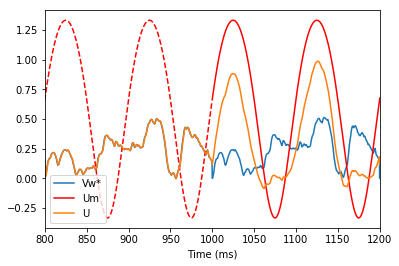

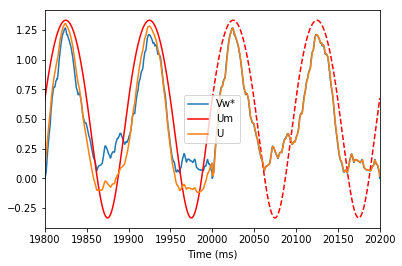

In [7]:
plt.plot(t,(g_d)/(g_l + g_d) * results_dict[neurons.Vw.name],label='Vw*')
t_c_ind_st = np.argmin(np.abs(t_c - start_osc))
t_c_ind_end = np.argmin(np.abs(t_c - end_osc))
plt.plot(t_c[:t_c_ind_st],Um_ref[:t_c_ind_st],'r--')
plt.plot(t_c[t_c_ind_st:t_c_ind_end],Um_ref[t_c_ind_st:t_c_ind_end],'r-',label='Um')
plt.plot(t_c[t_c_ind_end:],Um_ref[t_c_ind_end:],'r--')
plt.plot(t,results_dict[neurons.U.name],label = 'U')
plt.xlabel('Time (ms)')
plt.xlim([800,1200])
plt.legend()
plt.show()
plt.close()

plt.plot(t,(g_d)/(g_l + g_d) * results_dict[neurons.Vw.name],label='Vw*')
plt.plot(t_c[:t_c_ind_st],Um_ref[:t_c_ind_st],'r--')
plt.plot(t_c[t_c_ind_st:t_c_ind_end],Um_ref[t_c_ind_st:t_c_ind_end],'r-',label='Um')
plt.plot(t_c[t_c_ind_end:],Um_ref[t_c_ind_end:],'r--')
plt.plot(t,results_dict[neurons.U.name],label = 'U')
plt.xlabel('Time (ms)')
plt.xlim([19800,20200])
plt.legend()
plt.show()
plt.close()
    